# Analyse the Results of Running Moran Process Experiment on Different Graphs
This is the newest version of this analysis file, where I can merge the csv of different jobs. 

imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from analysis_utils import setup_analysis_environment, load_all_data, load_experiment_data, aggregate_results, plot_property_effect
# change this if on a different computer!
%cd /home/labs/pilpel/matanyaw/moran-process 
from population_graph import GRAPH_PROPS
# Set aesthetic parameters for "publication-quality" plots
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['lines.linewidth'] = 2.5

/home/labs/pilpel/matanyaw/moran-process


In [2]:
from pathlib import Path

batch_name = 'batch_20260127_155932'

ROOT = Path(os.getcwd()) 

# Now define your paths relative to ROOT
batch_dir = ROOT / "simulation_data" / "tmp" / batch_name
data_dir = ROOT / "simulation_data"




In [3]:
results_df = aggregate_results(batch_dir=batch_dir, save_to_dir=data_dir, delete_temp=True)
print("Results Dataframe Shape : ", results_df.shape)



File /home/labs/pilpel/matanyaw/moran-process/simulation_data/20260127_155932_results.csv already exitst! Not aggregating...
✓ Loaded /home/labs/pilpel/matanyaw/moran-process/simulation_data/20260127_155932_results.csv: (1200, 9)
Results Dataframe Shape :  (1200, 9)


In [4]:

# Extract data for use in notebook
df_graphs = load_experiment_data('graph_database.csv')       # Graph database


print("Shape before merging: ", results_df.shape)
results_df = pd.merge(
    results_df, 
    df_graphs, 
    on='wl_hash', 
    how='left', 
    suffixes=('', '_db')
)
print("Shape after merging: ", results_df.shape)


✓ Loaded graph_database.csv: (13, 32)
Shape before merging:  (1200, 9)
Shape after merging:  (1200, 40)


In [5]:
# Filter for successful fixations for time analysis
success_df = results_df[results_df['fixation'] == True]

# 1. Calculate P(fix) for every unique graph and r value
# Group by category, name, hash, and r
stats_prob = results_df.groupby(['wl_hash', 'r', 'graph_name',])['fixation'].mean().reset_index(name='prob_fixation')

# 2. Calculate Median Steps (Conditional on Fixation)
stats_time = success_df.groupby(['wl_hash', 'r', 'graph_name',])['steps'].median().reset_index(name='median_steps')

# 3. Merge metrics into a single analysis dataframe
analysis_df = pd.merge(stats_prob, stats_time, on=['wl_hash', 'r', 'graph_name',], how='outer')
analysis_df = pd.merge(
    analysis_df, 
    df_graphs, 
    on='wl_hash', 
    how='left', 
    suffixes=('', '_db')
)
analysis_df['z_order'] = np.where(analysis_df['category'] == 'Random', 0, 1)
analysis_df = analysis_df.sort_values('z_order')

analysis_df = analysis_df[analysis_df['category'] != 'Complete']

# Display sample
analysis_df.tail(20)

,wl_hash,r,graph_name,prob_fixation,median_steps,graph_name_db,graph_type,n_nodes,n_edges,is_directed,...,avg_closeness_centrality,max_closeness_centrality,category,branching,depth,n_rods,rods_length,rod_length,seed,z_order
0,6ce340cfc8a2dcdf4b8a7f7d78f74059,1.0,fish_r3_l3,0.05,14165.0,fish_r3_l3,NaN,30,29,False,...,0.208357,0.315217,Fish,NaN,NaN,3.0,NaN,3.0,NaN,1
1,6ce340cfc8a2dcdf4b8a7f7d78f74059,1.2,fish_r3_l3,0.21,5646.0,fish_r3_l3,NaN,30,29,False,...,0.208357,0.315217,Fish,NaN,NaN,3.0,NaN,3.0,NaN,1
2,6ce340cfc8a2dcdf4b8a7f7d78f74059,1.3,fish_r3_l3,0.35,5372.0,fish_r3_l3,NaN,30,29,False,...,0.208357,0.315217,Fish,NaN,NaN,3.0,NaN,3.0,NaN,1
3,6ce340cfc8a2dcdf4b8a7f7d78f74059,1.4,fish_r3_l3,0.25,3733.0,fish_r3_l3,NaN,30,29,False,...,0.208357,0.315217,Fish,NaN,NaN,3.0,NaN,3.0,NaN,1
4,8930697f2d93d4b53c61cfcce1af3ad2,1.0,mammalian_b2_d4,0.00,NaN,mammalian_b2_d4,NaN,31,30,False,...,0.208785,0.306122,Mammalian,2.0,4.0,NaN,NaN,NaN,NaN,1
5,8930697f2d93d4b53c61cfcce1af3ad2,1.2,mammalian_b2_d4,0.20,5384.0,mammalian_b2_d4,NaN,31,30,False,...,0.208785,0.306122,Mammalian,2.0,4.0,NaN,NaN,NaN,NaN,1
6,8930697f2d93d4b53c61cfcce1af3ad2,1.3,mammalian_b2_d4,0.27,4642.0,mammalian_b2_d4,NaN,31,30,False,...,0.208785,0.306122,Mammalian,2.0,4.0,NaN,NaN,NaN,NaN,1
7,8930697f2d93d4b53c61cfcce1af3ad2,1.4,mammalian_b2_d4,0.35,3864.0,mammalian_b2_d4,NaN,31,30,False,...,0.208785,0.306122,Mammalian,2.0,4.0,NaN,NaN,NaN,NaN,1
8,9c3de7e9fb2b11fbfca795d2a51c85f0,1.0,avian_r4_l7,0.04,1237.5,avian_r4_l7,NaN,31,34,False,...,0.233827,0.329670,Avian,NaN,NaN,4.0,7.0,NaN,NaN,1
9,9c3de7e9fb2b11fbfca795d2a51c85f0,1.2,avian_r4_l7,0.20,2348.5,avian_r4_l7,NaN,31,34,False,...,0.233827,0.329670,Avian,NaN,NaN,4.0,7.0,NaN,NaN,1


19


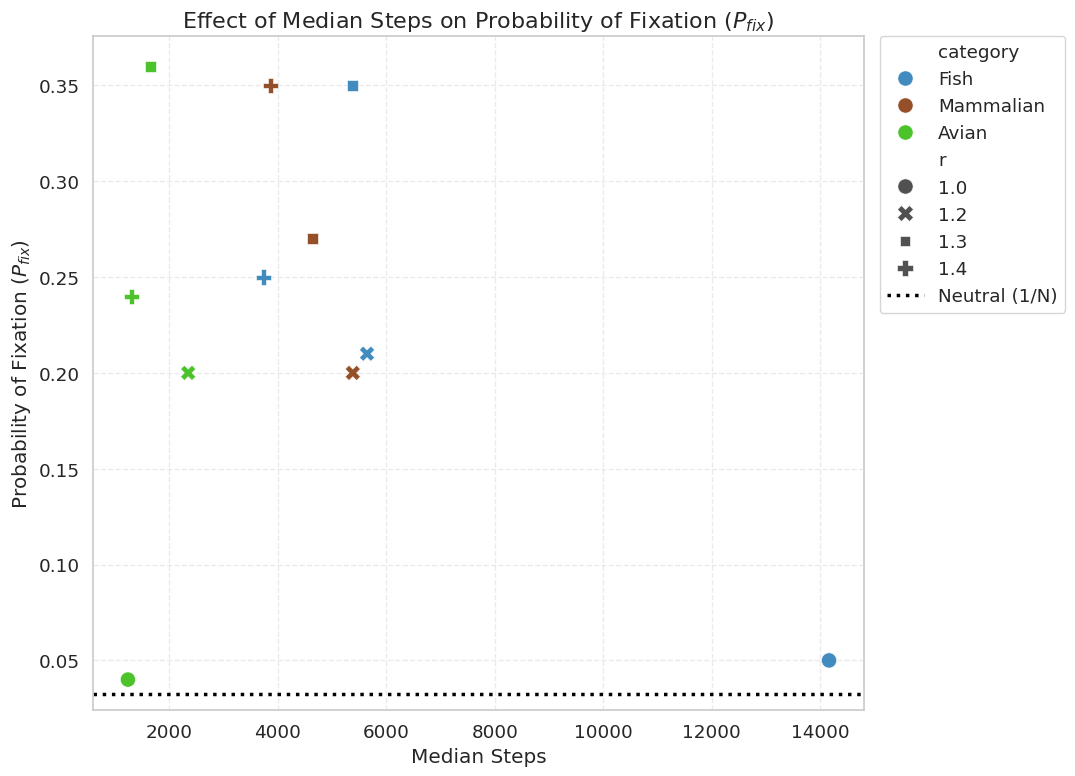

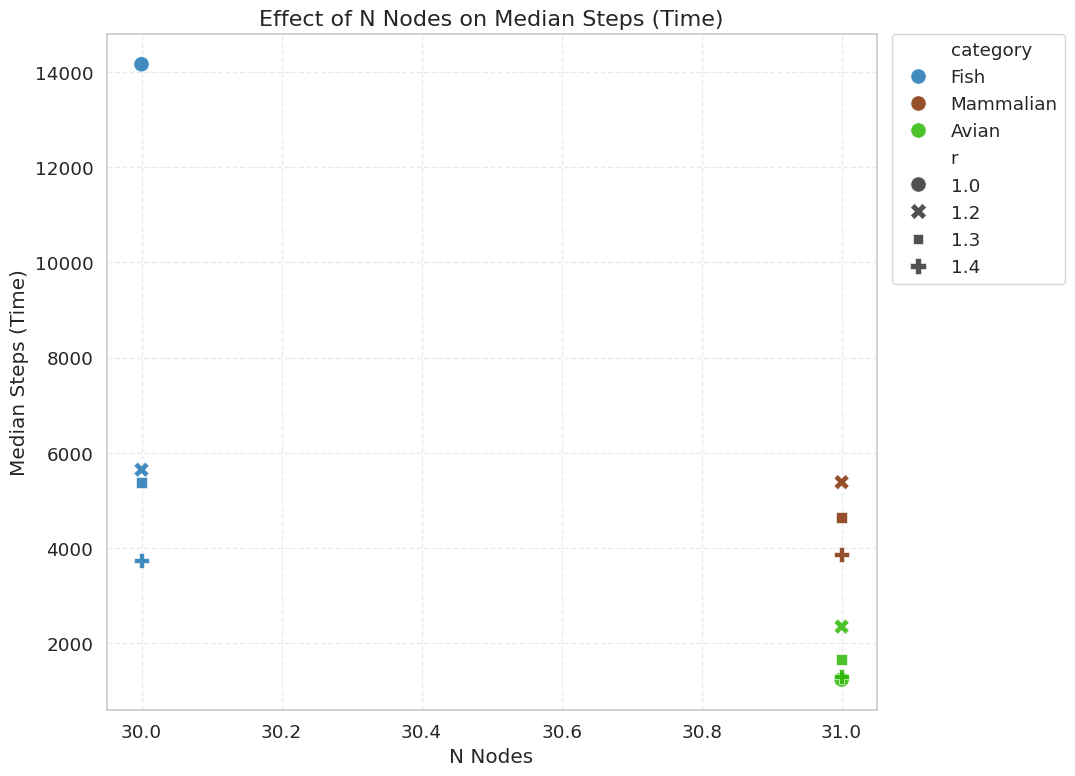

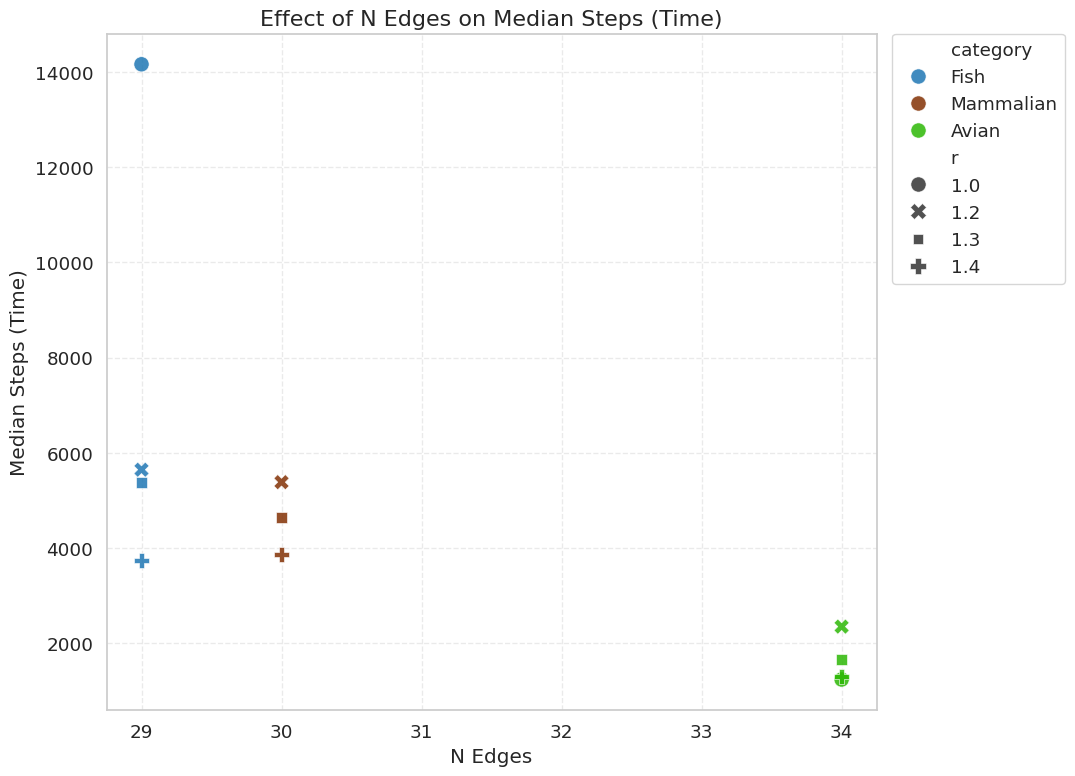

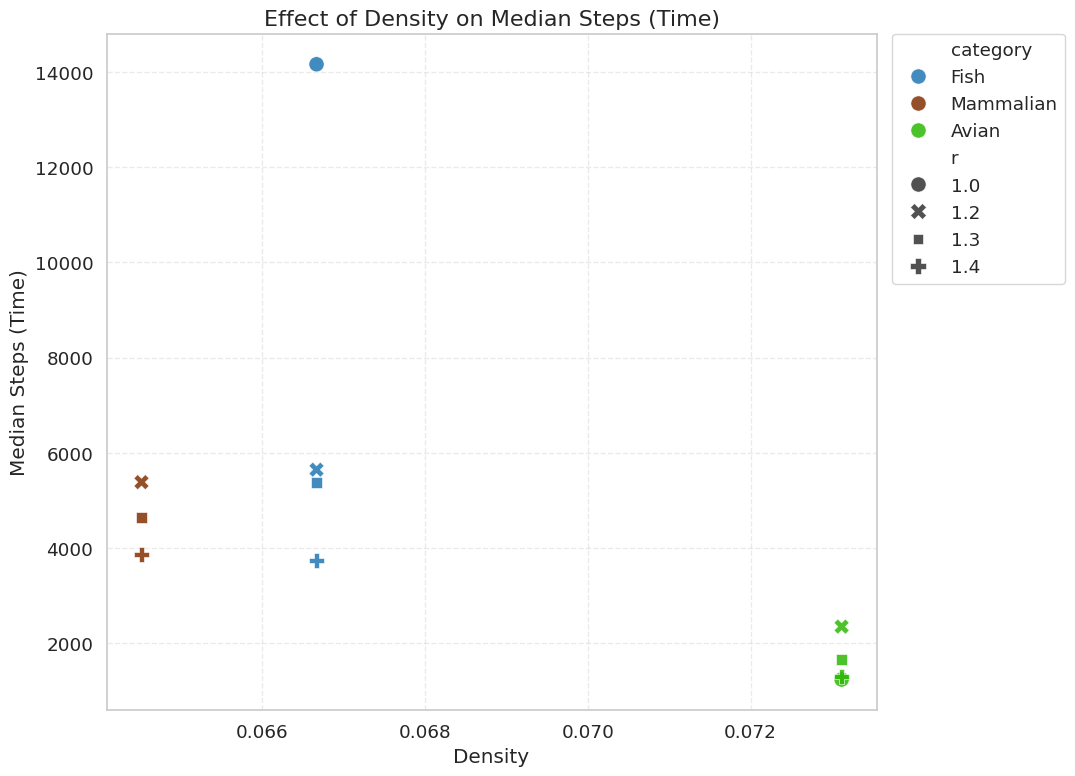

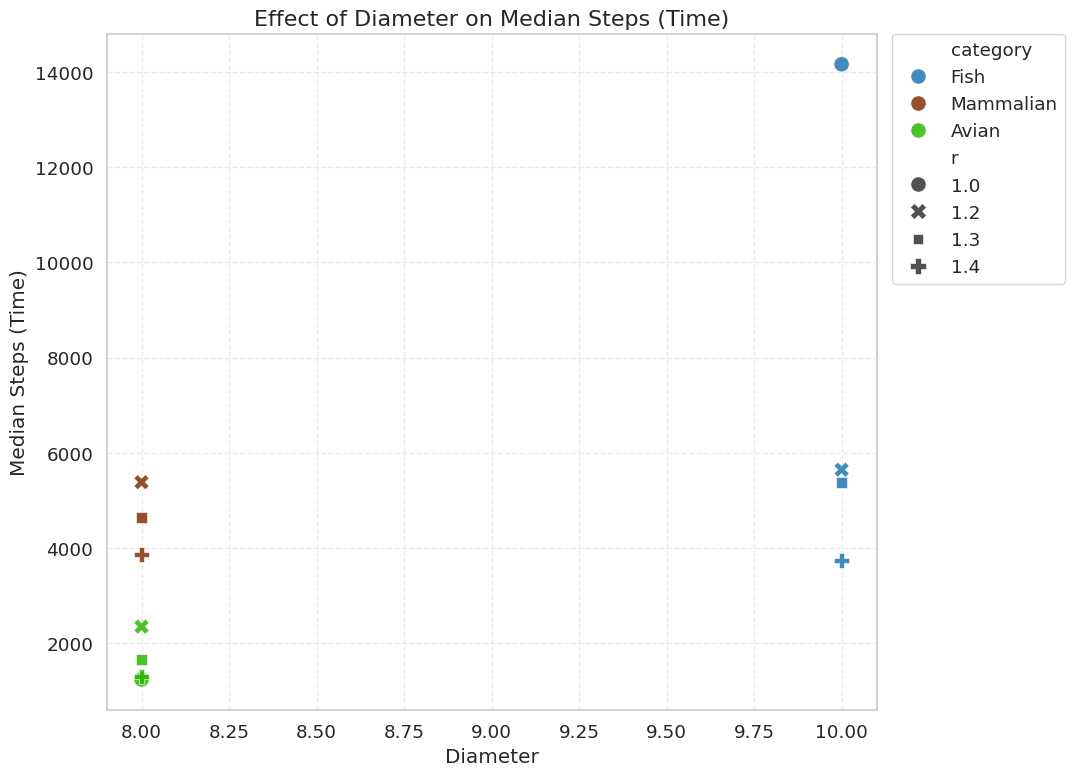

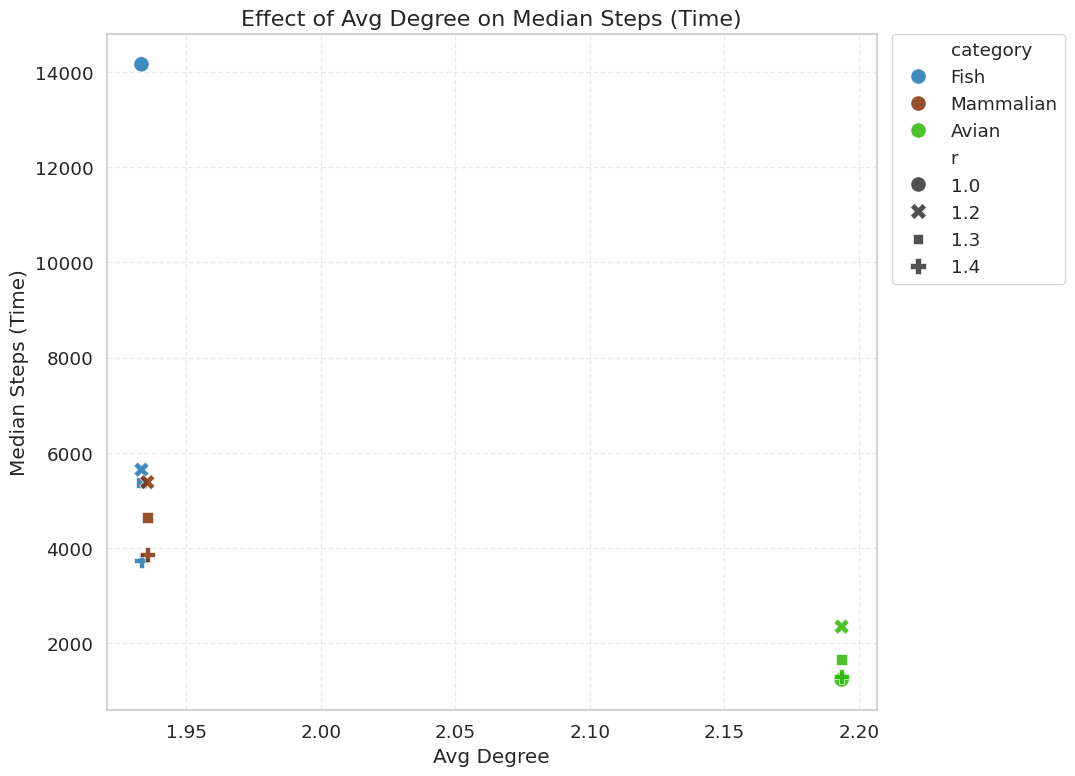

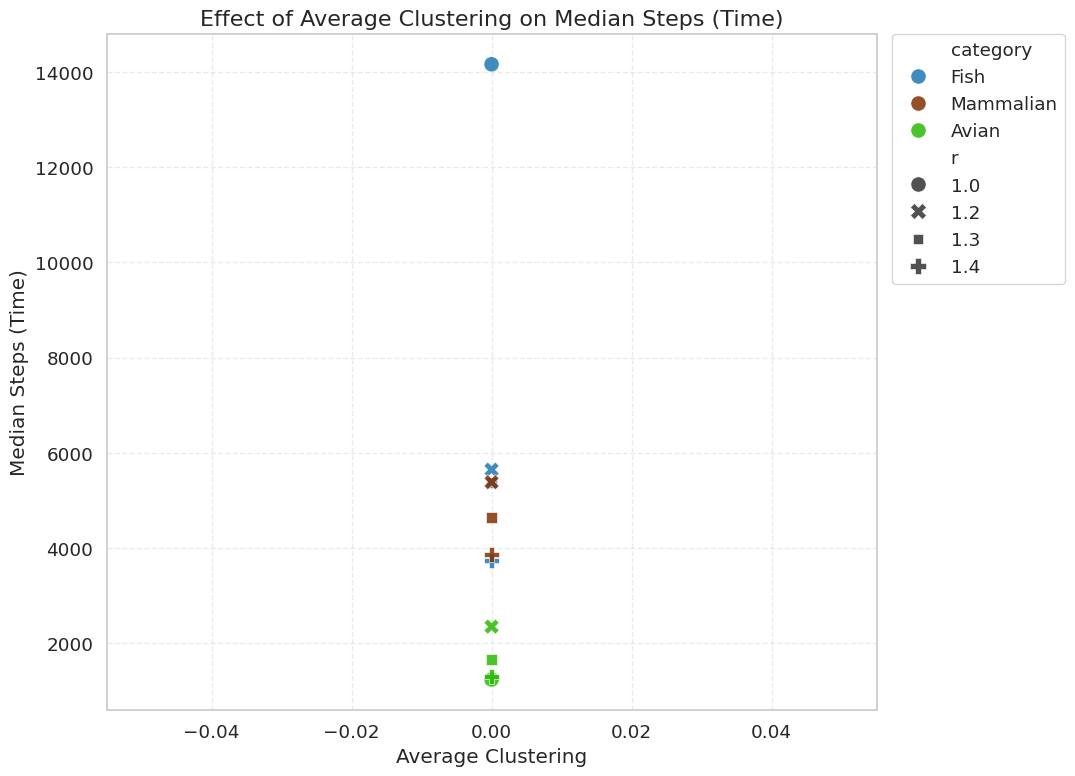

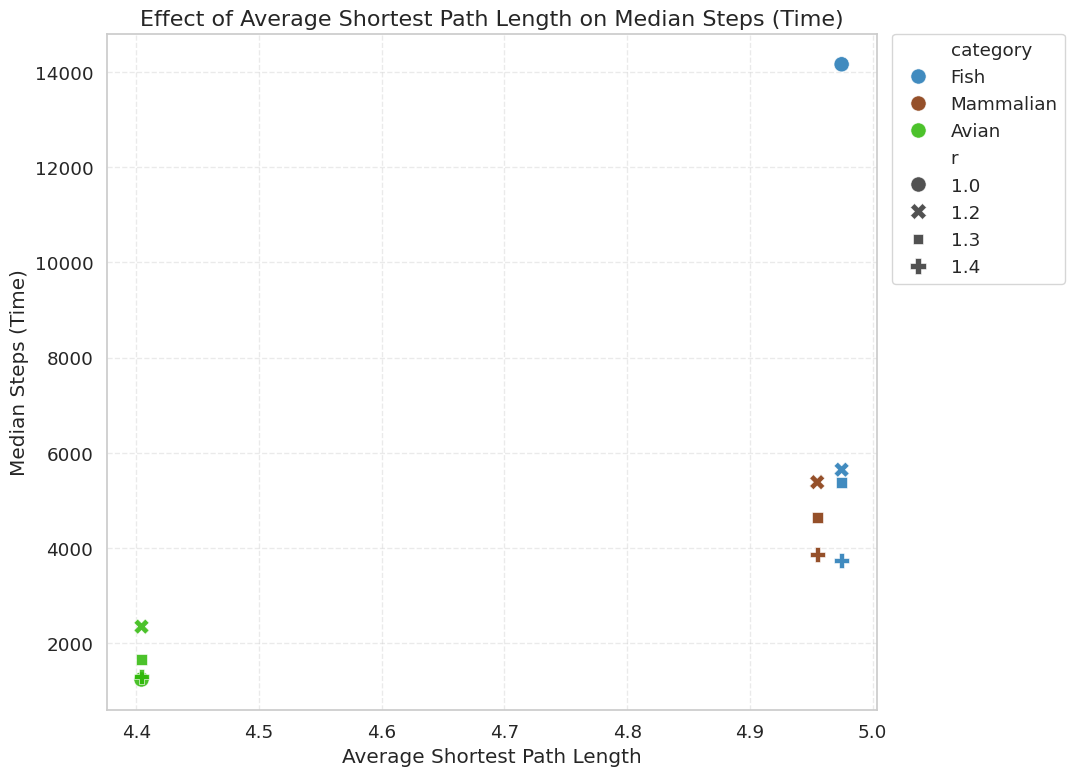

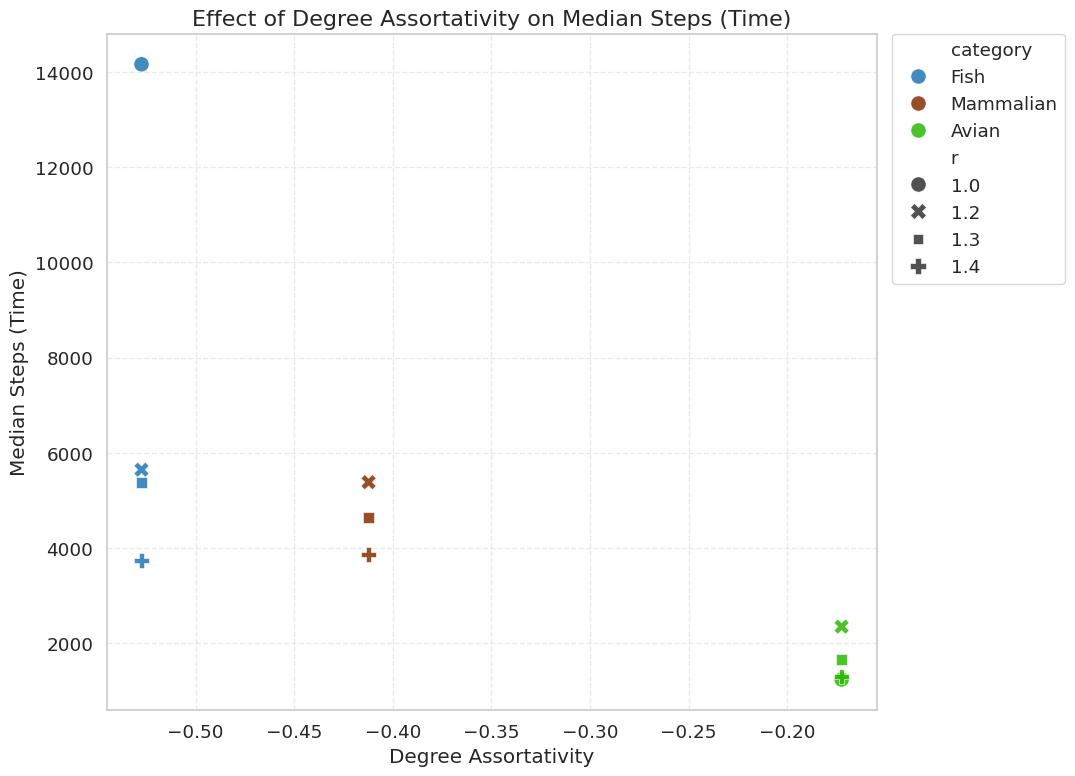

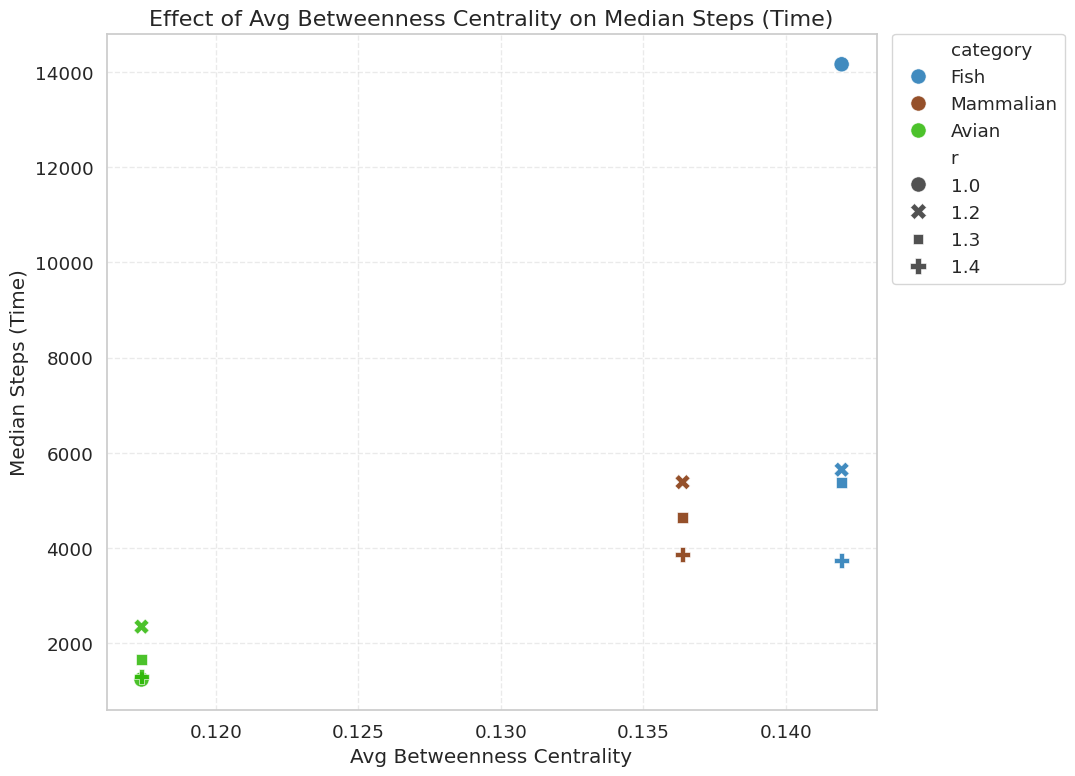

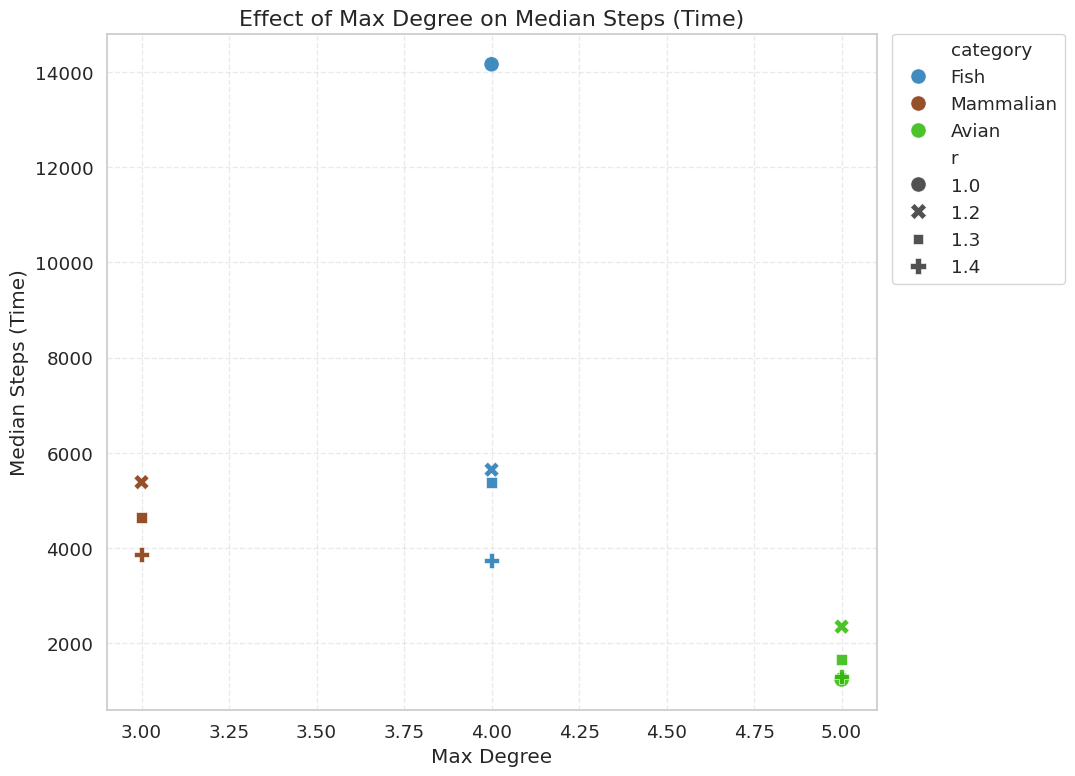

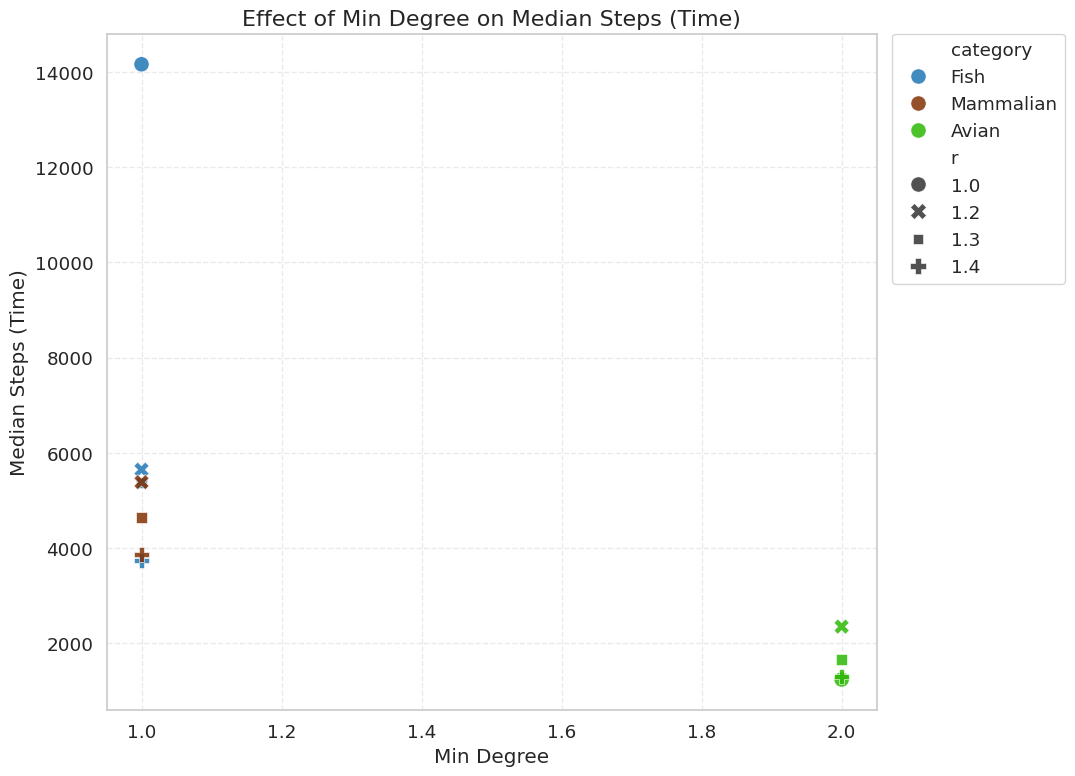

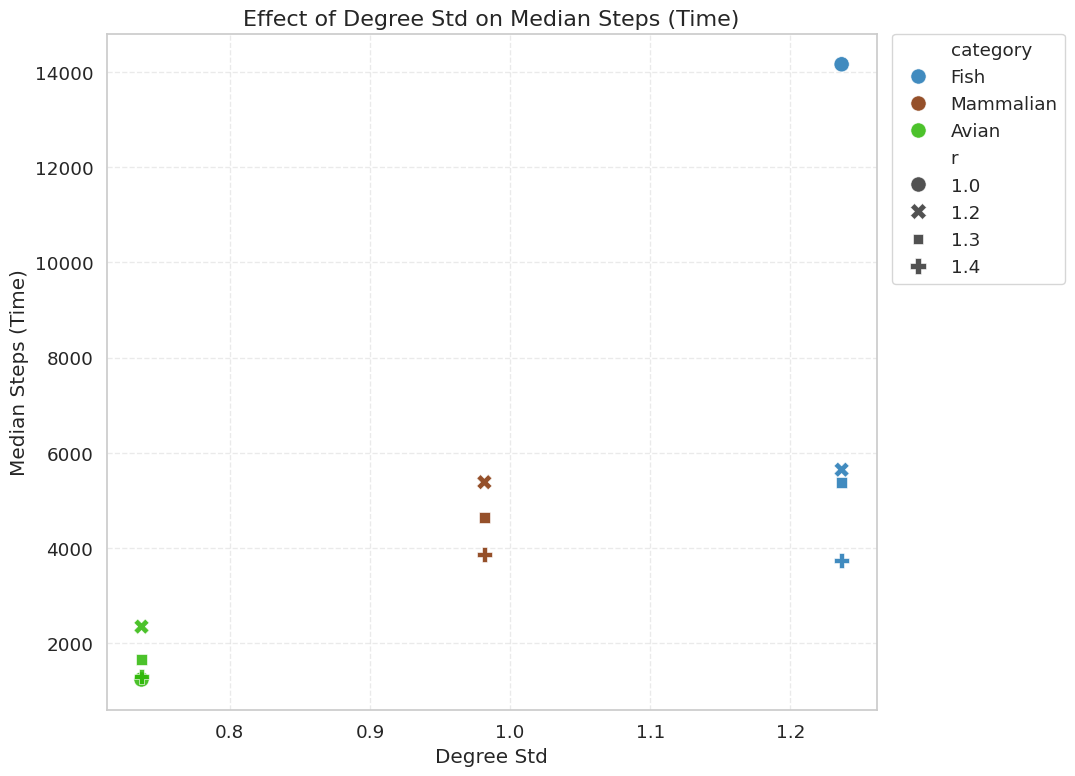

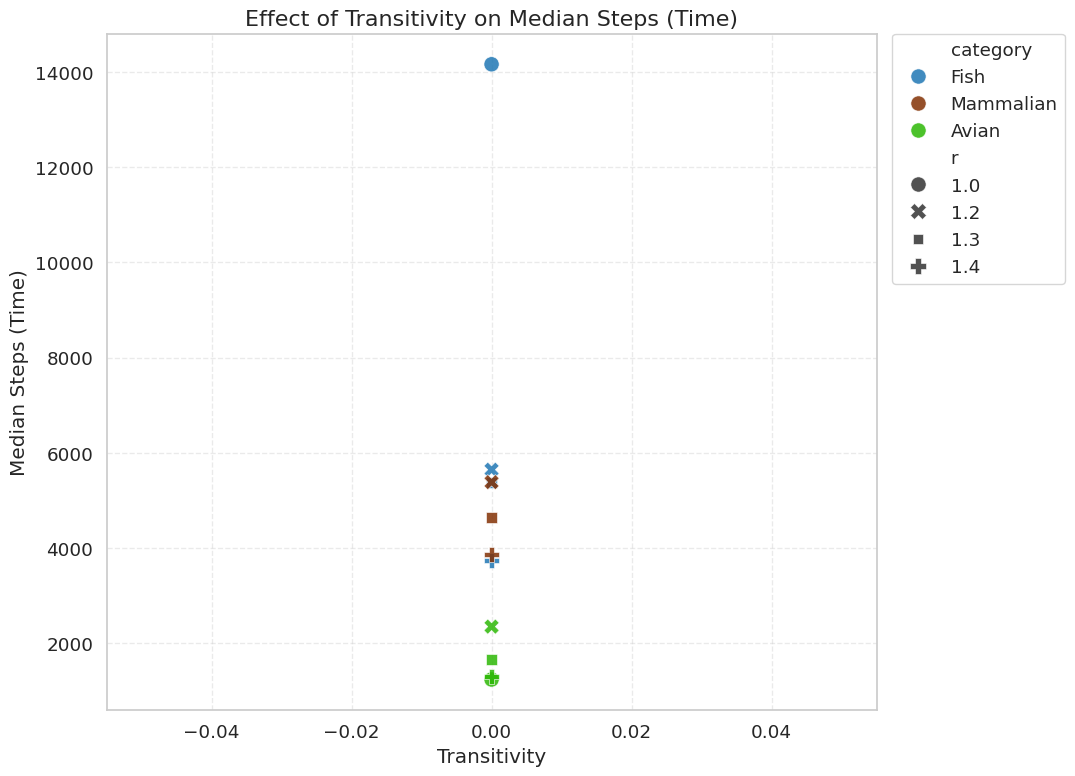

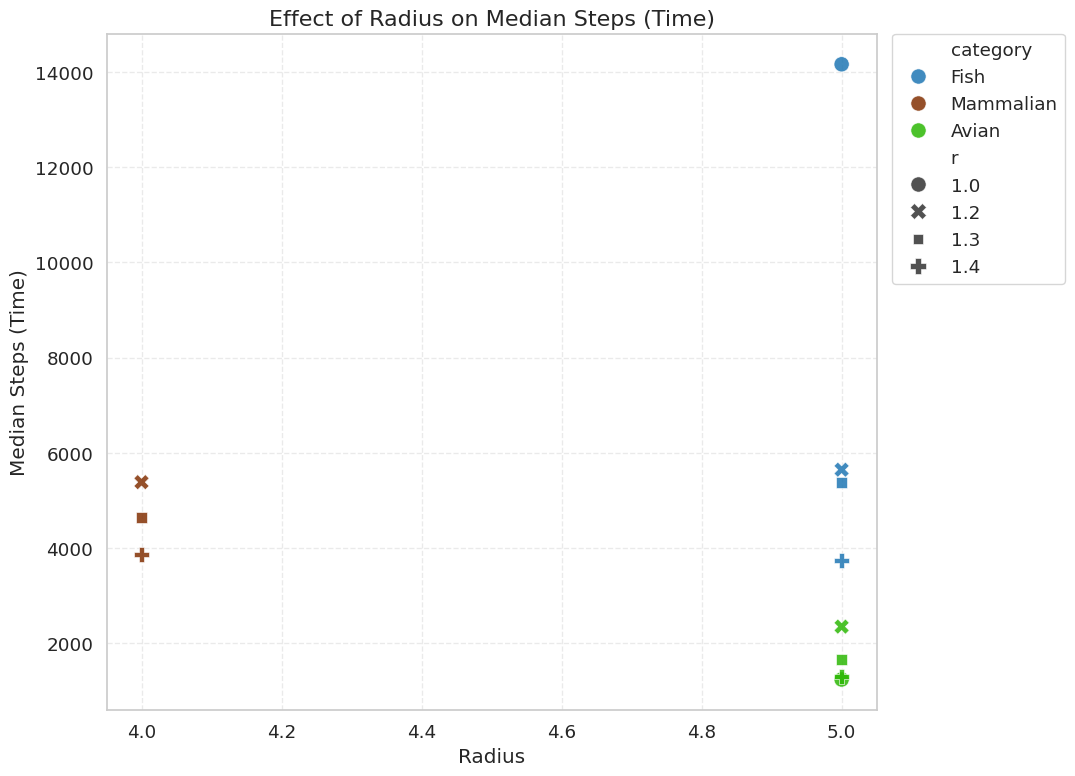

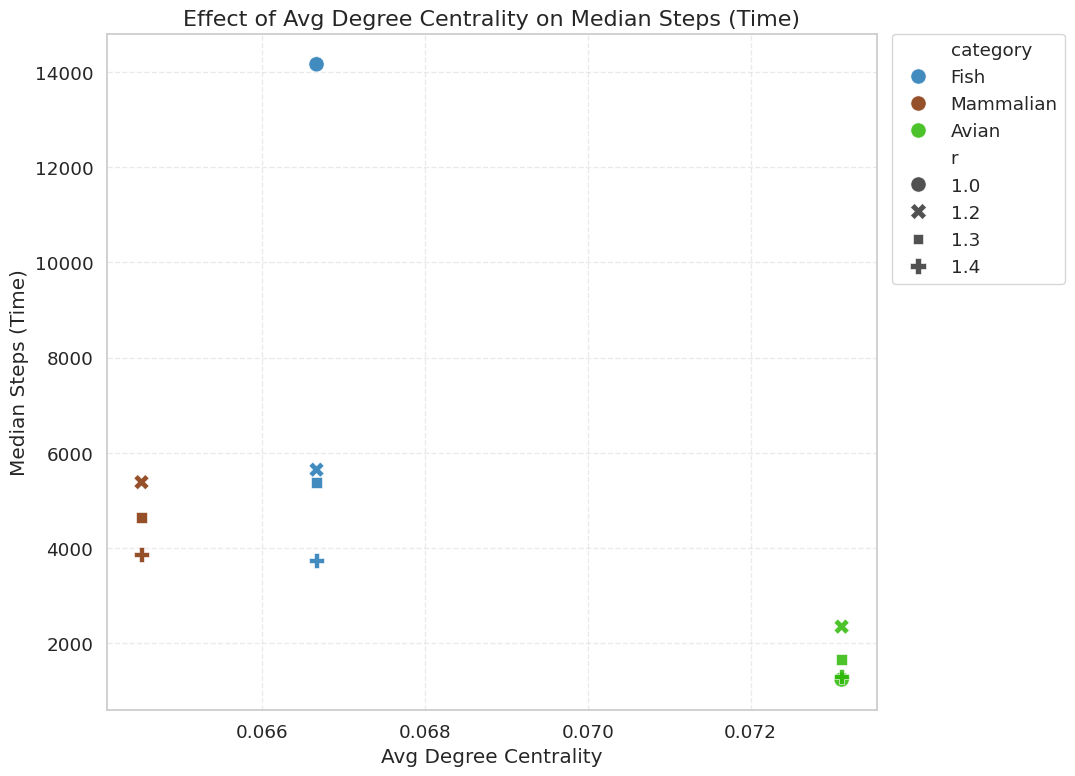

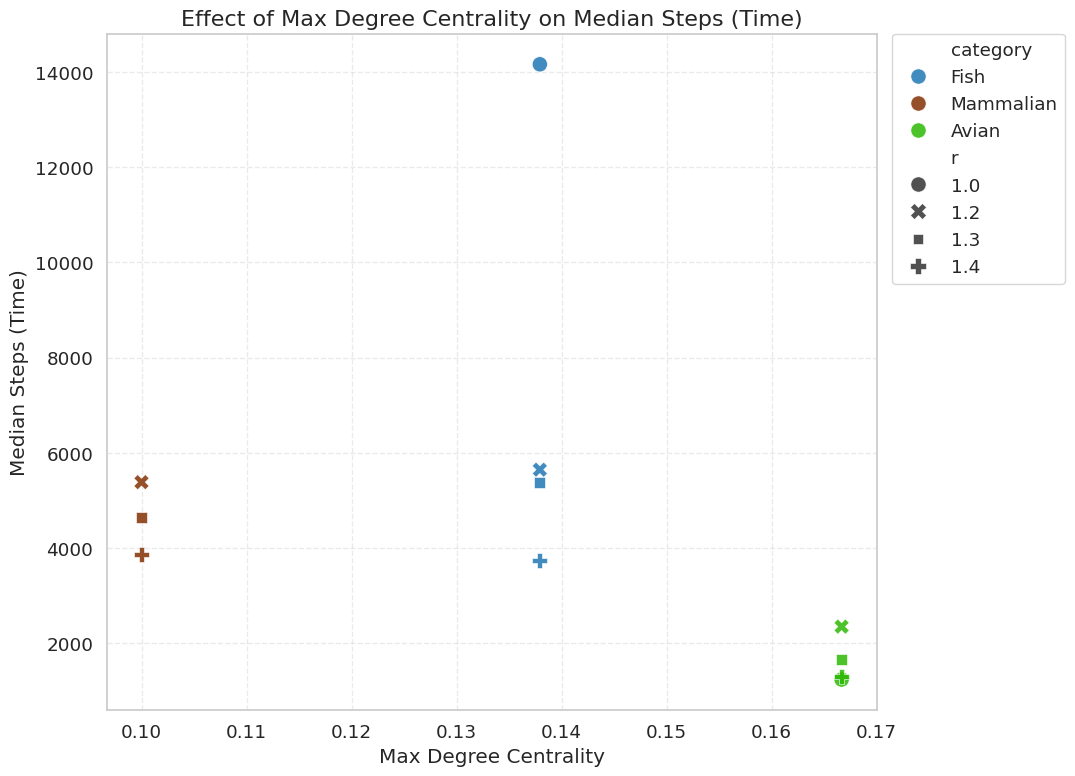

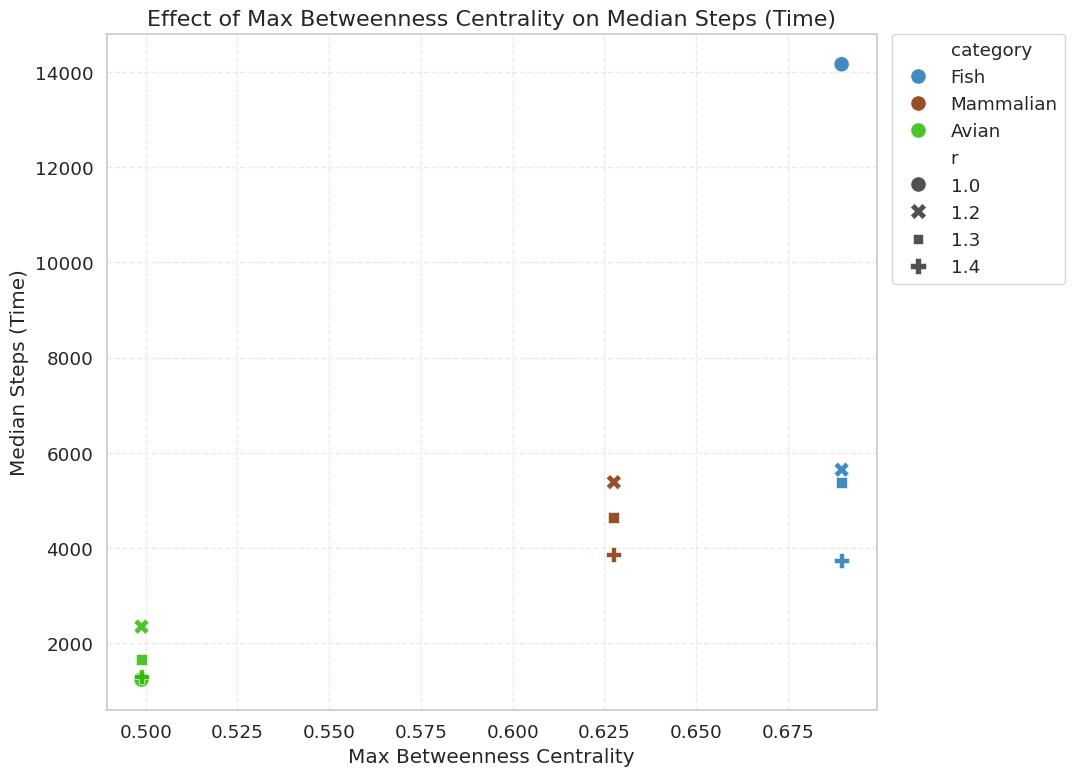

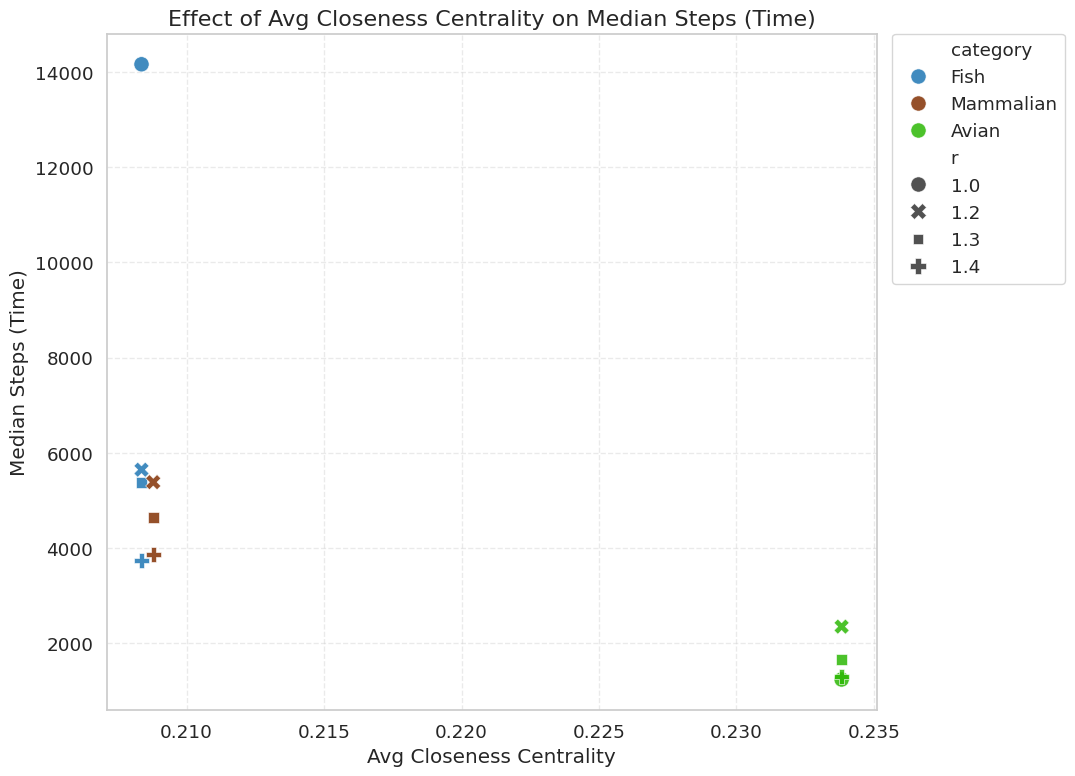

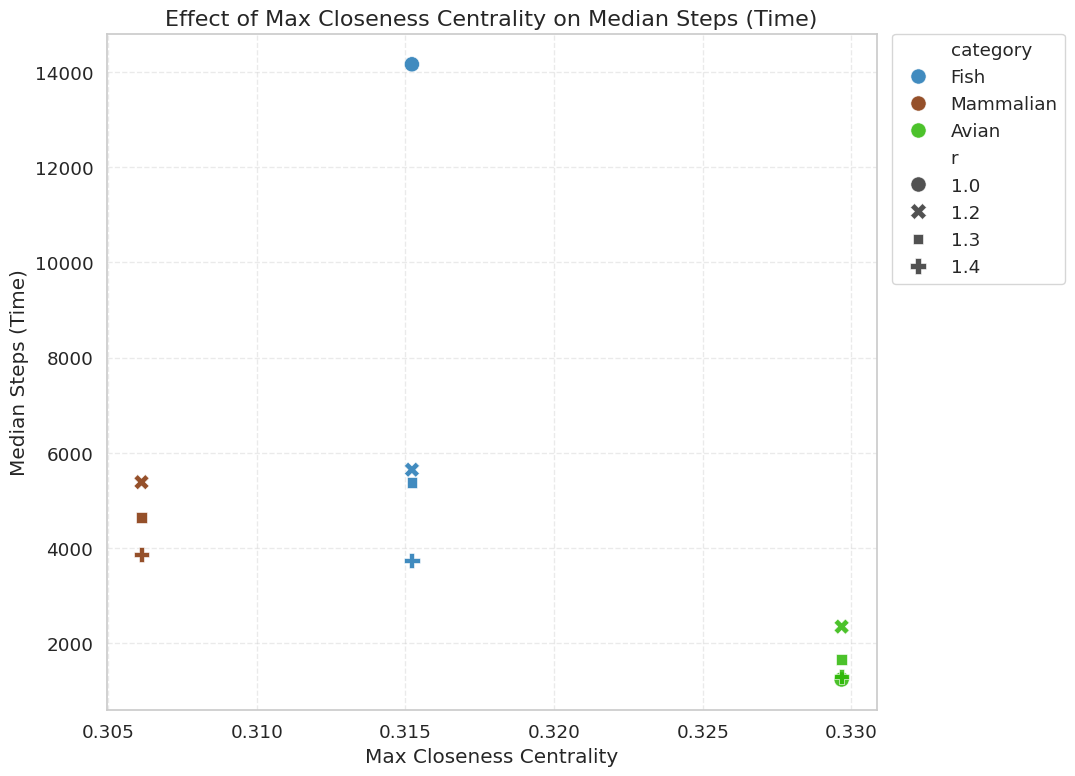

In [7]:

print(len(GRAPH_PROPS))
plot_property_effect(analysis_df, 'median_steps', 'prob_fixation')
# --- EXAMPLES OF USAGE ---
for prop in GRAPH_PROPS:
    plot_property_effect(analysis_df, prop, 'median_steps')